Testing ranking metrics, the impact of random (vs carefully weakly correlated) splitting into training and testing datasets, using ``TRANSCRIPT``.

## Imports

In [24]:
from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset
from stanscofi.training_testing import traintest_validation_split, print_folds, cv_training
from stanscofi.validation import compute_metrics, plot_metrics

from glob import glob
from time import time
import numpy as np

import sys
sys.path.insert(0,"src/")

import benchscofi

## Parameters

In [138]:
random_state = 1232454

########################
## Dataset parameters ##
########################
dataset_folder="datasets/"
dataset_names = ["TRANSCRIPT"]
split_params = {"metric": "cosine", "test_size": 0.2, "split_randomly": True}

##########################
## Algorithm parameters ##
##########################
algo_params = {
    "PMF": {
        'reg': 0.01,
        'learning_rate': 0.1,
        'n_iters': 160,
        'n_factors': 15,
        'batch_size': 100,
        'decision_threshold': 0.,
        'random_state': 12345,
    },
}

## Dataset import and splitting into training/testing datasets

In [99]:
#############
## Dataset ##
#############
dataset_name = dataset_names[0]
dataset_di = load_dataset(dataset_name, dataset_folder)
dataset_di.setdefault("same_item_user_features", dataset_name=="TRANSCRIPT")
dataset_di.setdefault("name", dataset_name)
dataset = Dataset(**dataset_di)

############################
## Weakly correlated sets ##
if (not split_params["split_randomly"]):
    train_set, test_set, _,_ = traintest_validation_split(dataset, test_size=split_params["test_size"], 
        early_stop=2, metric=split_params["metric"], disjoint_users=False, verbose=False, 
        random_state=random_state, print_dists=True)
######################
## Random splitting ##
else:
    from sklearn.model_selection import train_test_split
    X = np.array([[j,i] for i,j in np.argwhere(np.ones(dataset.ratings_mat.shape))])
    y = dataset.ratings_mat.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_params["test_size"], 
                            random_state=random_state, shuffle=True, stratify=y)
    train_set = np.asarray(np.concatenate((X_train, y_train.reshape(-1,1)),axis=1), dtype=int)
    test_set = np.asarray(np.concatenate((X_test, y_test.reshape(-1,1)),axis=1), dtype=int)

###################################################################
## Algorithm-related splitting into training and testing dataset ##
###################################################################
use_masked_dataset = True
if (use_masked_dataset):
    train_dataset = dataset.mask_dataset(train_set)
    test_dataset = dataset.mask_dataset(test_set)
else:
    train_dataset = dataset.get_folds(train_set)
    test_dataset = dataset.get_folds(test_set)

## Initializing model

In [139]:
###############
## Algorithm ##
###############
algo = [a for a in algo_params][0]
__import__("benchscofi."+algo)

from importlib import reload
reload(benchscofi)
reload(benchscofi.PMF)
reload(benchscofi.implementations.BayesianPairwiseRanking)

model = eval("benchscofi."+algo+"."+algo)(algo_params[algo])

## Training

In [140]:
###############
## Training  ##
###############
model.fit(train_dataset)

BPR: 100%|███████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 424.58it/s]


## Testing

In [141]:
#################
## Predictions ##
#################
scores = model.predict(test_dataset)
predictions = model.classify(scores)

model.print_scores(scores)
model.print_classification(predictions)

* Scores
613 unique items, 151 unique users
Scores: Min: -13.298264	Mean: 0.001044	Median: 0.000000	Max: 13.685775	Std: 1.424633

* Classification
613 unique items, 151 unique users
Positive class: 83284, Negative class: 9279



## Validation

### Disease-wise metrics

<validation.compute_metrics> Computed on #users=151, 97 ignored (64 perc)


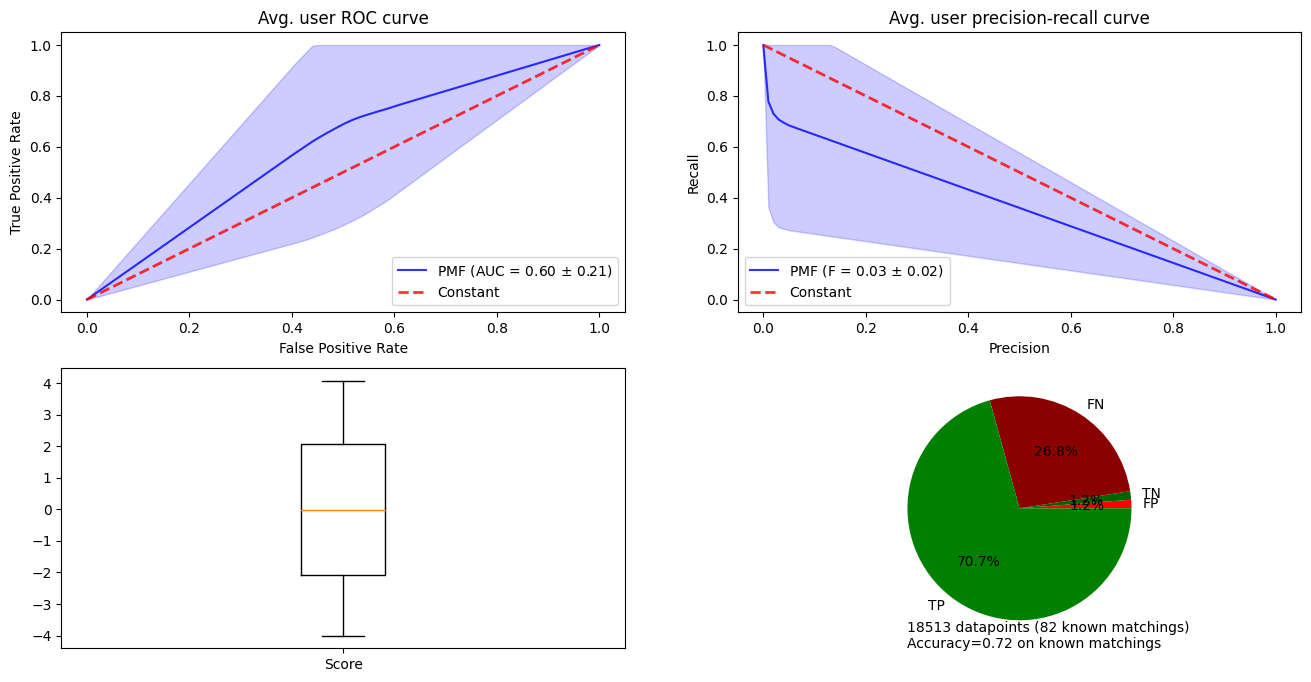

,Avg. across users,Std
AUC,0.600749,0.213506
F_1.0,0.033471,0.024978


In [142]:
#################
## Validation  ##
#################

from stanscofi.validation import compute_metrics, plot_metrics

## disease-wise metrics
metrics, plot_args = compute_metrics(scores, predictions, test_dataset, beta=1, ignore_zeroes=0, verbose=1)
plot_args.update({"model_name": "PMF", "figsize": (16,8)})
plot_metrics(**plot_args)
metrics

In [314]:
ids = np.argwhere(np.ones(test_dataset.ratings_mat.shape))

ignore_zeroes = True

## If not ignore zeroes (count them towards negative)
if (not ignore_zeroes):
    folds_ids = [((test_dataset.folds[:,0]==j)&(test_dataset.folds[:,1]==i)).any() for i,j in ids[:,:2].tolist()]
    y_true_all = (np.ravel(test_dataset.ratings_mat)[folds_ids]>0).astype(int) 
## If ignore zeroes (only use 1's and -1's)
else:
    folds_ids = [((test_dataset.folds[:,0]==j)&(test_dataset.folds[:,1]==i)&(test_dataset.folds[:,2]!=0)).any() for i,j in ids[:,:2].tolist()]
    y_true_all = (np.ravel(test_dataset.ratings_mat)[folds_ids]>0).astype(int) 

scores_ = scores[folds_ids,:]
y_pred_all = scores_[:,2].ravel()

In [315]:
## One-hot conversion of true and fuzzy conversion of predicted labels
y_true_oh = np.zeros((y_true_all.shape[0],2))
for ix, x in enumerate((y_true_all>0).astype(int)):
    y_true_oh[ix,x] = 1
y_pred_oh = np.zeros((y_pred_all.shape[0],2))
for ix, x in enumerate((y_pred_all>model.decision_threshold).astype(int)):
    y_vals = np.zeros(2)
    y_vals[x] = np.abs(y_pred_all[ix])
    basal = 0.5 ## exact value does not influence the ranking
    y_pred_oh[ix,:] = (y_vals+basal)/np.sum(y_vals+basal)

## test if OK for y_true
assert (y_true_oh.sum(axis=1)==1).all()

if (not ignore_zeroes):
    assert y_true_oh.sum(axis=0).sum()==test_dataset.folds.shape[0]
    assert y_true_oh.sum(axis=0)[0]==(test_dataset.folds[:,2]<1).sum()
    assert y_true_oh.sum(axis=0)[1]==(test_dataset.folds[:,2]==1).sum()
    ## test if OK for y_pred
    assert y_pred_oh.shape[0]==test_dataset.folds.shape[0]
else:
    assert y_true_oh.sum(axis=0).sum()==test_dataset.ratings.shape[0]
    assert y_true_oh.sum(axis=0)[0]==(test_dataset.ratings[:,2]<1).sum()
    assert y_true_oh.sum(axis=0)[1]==(test_dataset.ratings[:,2]==1).sum()
    ## test if OK for y_pred
    assert y_pred_oh.shape[0]==test_dataset.ratings.shape[0]

In [316]:
y_true_oh #np.argmax(y_true_oh,axis=1) gives classes

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [317]:
y_pred_oh #np.argmax(y_pred_oh,axis=1) gives classes

array([[0.11328387, 0.88671613],
       [0.1438799 , 0.8561201 ],
       [0.8863003 , 0.1136997 ],
       [0.17695763, 0.82304237],
       [0.09359136, 0.90640864],
       [0.47704586, 0.52295414],
       [0.14005037, 0.85994963],
       [0.25444978, 0.74555022],
       [0.18668033, 0.81331967],
       [0.11655388, 0.88344612],
       [0.14248998, 0.85751002],
       [0.40001909, 0.59998091],
       [0.24206775, 0.75793225],
       [0.11858924, 0.88141076],
       [0.17483099, 0.82516901],
       [0.0772106 , 0.9227894 ],
       [0.15965208, 0.84034792],
       [0.50024161, 0.49975839],
       [0.08254891, 0.91745109],
       [0.13869022, 0.86130978],
       [0.05087713, 0.94912287],
       [0.91533917, 0.08466083],
       [0.86608384, 0.13391616],
       [0.1450161 , 0.8549839 ],
       [0.11598467, 0.88401533],
       [0.36962743, 0.63037257],
       [0.79078026, 0.20921974],
       [0.30409206, 0.69590794],
       [0.05804357, 0.94195643],
       [0.24048279, 0.75951721],
       [0.

### Full dataset metrics

In [318]:
## full test_dataset metrics
from sklearn.metrics import roc_auc_score, accuracy_score

print("AUC=%f" % roc_auc_score(y_true_all, y_pred_all))
print("ACC=%f" % accuracy_score(y_true_all, (y_pred_all>model.decision_threshold).astype(int)))

AUC=0.543750
ACC=0.719512


### Ranking metrics

#### DCG / NCDG

Formula for normalized discounted cumulative gain (NDCG) up to rank $k<N=$\#pairs on the ranking on pairs by *decreasing* predicted score given by the permutation $\sigma : \{p_1,p_2,\dots,p_k,p_{k+1},\dots,p_N\} \rightarrow [N]=\{1,2,\dots,N\}$, and the list of true scores $t : \{p_1,p_2,\dots,p_k\} \rightarrow \mathbb{R}$ corresponding to the ideal permutation $\sigma^\star$ (such that $(\sigma^\star)^{-1}(1) = \arg\max_{i}t(p_i)$, $\dots$, $(\sigma^\star)^{-1}(N)=\arg\min_{i}t(p_i)$):

$$ \text{nDCG}_k(\sigma,t) := \underbrace{\sum_{i=1}^k \frac{t[\sigma^{-1}(i)]}{\log_2(i+1)}}_\text{DCG$_k(\sigma,t)$} / \underbrace{\sum_{j=1}^k \frac{t[(\sigma^\star)^{-1}(j)]}{\log_2(j+1)}}_\text{ideal DCG$_k(\sigma,t)$=DCG$_k(\sigma^\star,t)$}\;.$$

In [319]:
## ranking metrics
from sklearn.metrics import ndcg_score

#y_true_ndcg = np.asarray([y_true_all.tolist()])
#y_pred_ndcg = np.asarray([y_pred_all.tolist()])
y_true_ndcg = y_true_oh.T
y_pred_ndcg = y_pred_oh.T

for k in [None, 2, 5, 10, 20, np.argmax(relevance_values_ranked)+1]:
    print("NDCG%d=%f" % (
        0 if (k is None) else k, 
        ndcg_score(y_true_ndcg, y_pred_ndcg, k=k)
    ))

NDCG0=0.698947
NDCG2=0.500000
NDCG5=0.653287
NDCG10=0.621476
NDCG20=0.632757
NDCG1=0.500000


**Notation:** Let us consider the ranking on $N$ pairs by *decreasing* predicted score identified by $\{1,2,\dots,N\}$ given by permutation $\sigma : \{p_1,p_2,\dots,p_k,p_{k+1},\dots,p_N\} \rightarrow [N]=\{1,2,\dots,N\}$, and the list of true scores $t : \{p_1,p_2,\dots,p_k\} \rightarrow \mathbb{R}$. $N_\text{pos}$ is the number of positive pairs among the $N$ ones.

#### Mean reciprocal rank (MRR)

Here, we only perform one ''query'' (retrieve a positive pair) and as such, the corresponding rank of the correct answer in our case is the minimum rank of a positive pair in the ranking by predicted scores:

$$ \text{MRR}(\sigma,t) := \arg\min_{\substack{r \in [N]\\t[\sigma^{-1}(r)]=1}} 1/r\;.$$

#### R-Precision

$$ \text{RP}(\sigma,t) := \frac{\sum_{r=1}^{N_\text{pos}} \delta(t[\sigma^{-1}(r)]=1)}{N_\text{pos}}\;.$$

#### Precision @ k

$$ \text{Prec@}k(\sigma,t) := \frac{\sum_{r=1}^{k} \delta(t[\sigma^{-1}(r)]=1)}{k}\;.$$

#### Average Precision (AP)

$$ \text{AP}(\sigma,t) := \frac{1}{N_\text{pos}}\sum_{r=1}^{N_\text{pos}}\text{Prec@}r(\sigma,t)\;.$$

#### Mean Average Precision (mAP)

Since we only have one class, in our case mAP=AP.

In [324]:
import subprocess as sb
url_code="https://gist.githubusercontent.com/bwhite/3726239/raw/2c92e90259b01b4a657d20c0ad8390caadd59c8b/rank_metrics.py"
sb.call("wget -qnc %s" % url_code, shell=True)
from rank_metrics import *

## True classes for each pair ranked by the corresponding predicted score
relevance_values_ranked = y_true_all[np.argsort(-y_pred_all)]

k=np.argmax(relevance_values_ranked)+1 ## rank of first positive item in predicted ranking

import pandas as pd
pd.DataFrame([
    [mean_reciprocal_rank([relevance_values_ranked])],
    [r_precision(relevance_values_ranked)],
    [precision_at_k(relevance_values_ranked, k)],
    [average_precision(relevance_values_ranked)],
    [mean_average_precision([relevance_values_ranked])],
    [dcg_at_k(relevance_values_ranked, k, method=0)],
    [ndcg_at_k(relevance_values_ranked, k, method=0)], 
    ## not the same value as in scikit-learn??
], columns=["values"], index=["MRR","RP","Prec@%d" % k, "AP", "mAP", "DCG@%d" % k,
                             'NDCG@%d' % k])

,values
MRR,1.000000
RP,0.975610
Prec@1,1.000000
AP,0.974086
mAP,0.974086
DCG@1,1.000000
NDCG@1,1.000000


#### Label ranking average precision (LRAP)

**Notation:** Let us consider $N$ pairs, and the ground truth for pair $i \leq N$ $y_i \in \{0,1\}^2$ ($\|y_i\|_0=1$) and the corresponding predicted score $\hat{y}_i \in [0,1]^2$ ($\|\hat{y}_i\|_1=1$), since, in our case, there is only one single class.

$$\text{LRAP}(p,t) := \frac{1}{N}\sum_{i=1}^N \frac{1}{1+\delta(\hat{y}_i[0]\geq \hat{y}_i[1])}\;.$$

In [322]:
from sklearn.metrics import label_ranking_average_precision_score

print("LRAP=%f" % (label_ranking_average_precision_score(y_true_ndcg, y_pred_ndcg)))

LRAP=0.577226


#### Kendall's $\tau$

If $N_\text{dis}$ is the number of discordant pairs between predicted scores $p$ and true labels $t$ (i.e., $(i,j)$ such that $p[i]<p[j] \land t[i]>t[j]$ or $p[j]<p[i] \land t[j]>t[i]$)

$$\tau(p,t) = 1 - \frac{2N_\text{dis}(p,t)}{C^n_2}\;.$$

A smarter version is implemented in ``scipy`` which takes into account ties.

#### Spearman's $r$

Roughly Pearson correlation on ranks instead of scores.

#### Expected reciprocal rank (ERR)

Here, we consider a single query (find one positive pair). If $\sigma$ is the ranking induced by decreasing predicted scores and $t$ the true binary labels on $N$ pairs. This is supposed to introduce some dependency with prior elements encountered in the ranking [[ref]](https://dl.acm.org/doi/abs/10.1145/1645953.1646033)

$$\text{ERR} := \sum_{k=1}^N \frac{1}{k}t[\sigma^{-1}(k)]\Pi_{i=1}^{k-1}(1-t[\sigma^{-1}(i)])\;.$$

In [333]:
from scipy.stats import kendalltau, spearmanr

## True classes for each pair ranked by the corresponding predicted score
predicted_values_ranked = y_pred_all[np.argsort(-y_true_all)]
ground_truth_ranking = np.array([1]*np.sum(y_true_all==1)+[0]*np.sum(y_true_all<1))

res = kendalltau(predicted_values_ranked, ground_truth_ranking)
print("Kendall tau=%f (p=%f)" % (res.correlation, res.pvalue))

res = spearmanr(predicted_values_ranked, ground_truth_ranking)
print("Spearman r=%f (p=%f)" % (res.correlation, res.pvalue))

Kendall tau=0.019206 (p=0.833339)
Spearman r=0.023380 (p=0.834843)


In [337]:
import subprocess as sb
url_code="https://raw.githubusercontent.com/skondo/evaluation_measures/master/evaluations_measures.py"
sb.call("wget -qnc %s" % url_code, shell=True)
#from evaluations_measures import *

# ERR (Expected Reciprocal Rank)
# NOTE: max_grade should be *2*
def err(ranking, max=10, max_grade=2):
    if max is None:
        max = len(ranking)
    
    ranking = ranking[:min(len(ranking), max)]
    ranking = map(float, ranking)

    result = 0.0
    prob_step_down = 1.0
    
    for rank, rel in enumerate(ranking):
        rank += 1
        utility = (pow(2, rel) - 1) / pow(2, max_grade)
        result += prob_step_down * utility / rank
        prob_step_down *= (1 - utility) 
      
    return result

## True classes for each pair ranked by the corresponding predicted score
relevance_values_ranked = y_true_all[np.argsort(-y_pred_all)]

print("ERR=%f" % err(relevance_values_ranked, max=10, max_grade=2))

ERR=0.456009
